In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix, f1_score, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# caminho do dataset
PATH = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'
IMAGE_SHAPE = (224, 224)

In [3]:
dataset = datasets.ImageFolder(PATH)

# Defina algumas transformações - Conversão para tensor será necessária para visualização
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Magia do PIL para exibir as imagens
to_pil = transforms.ToPILImage()

# Contagem de amostras
count = dict()
for _, target in dataset:
    label = dataset.classes[target]
    if label not in count:
        count[label] = 0
    count[label] += 1

print(f"Quantidades para cada classe: {count}")

Quantidades para cada classe: {'MildDemented': 717, 'ModerateDemented': 52, 'NonDemented': 2560, 'VeryMildDemented': 1792}


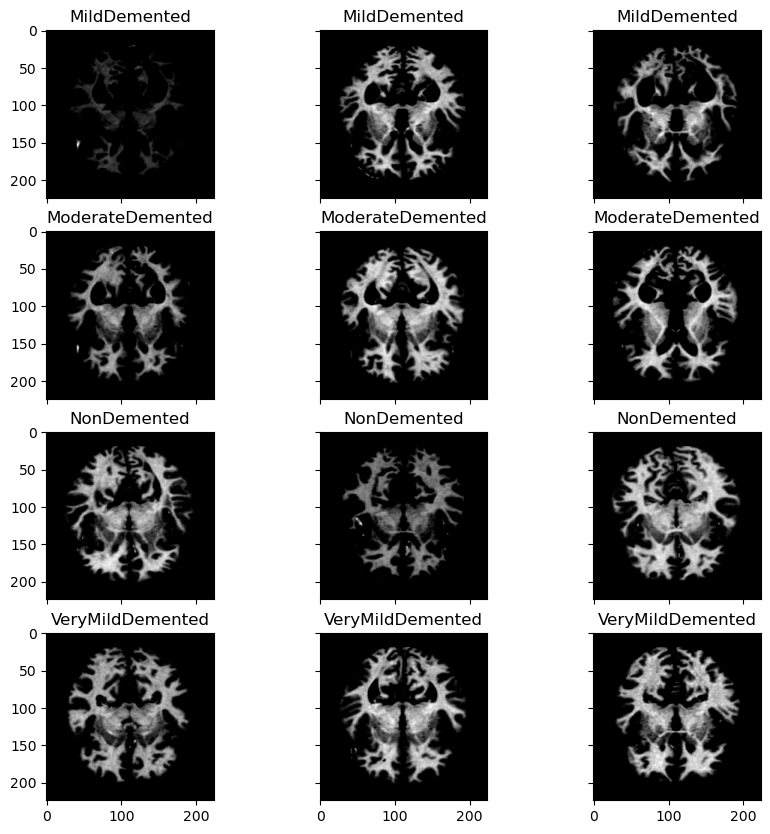

In [4]:
classes = dataset.classes
max_images_per_class = 3

# Plote algumas imagens de cada classe
class_counts = {class_label: 0 for class_label in classes}
fig, axs = plt.subplots(len(classes), max_images_per_class, figsize=(10, 10))

for image, label in dataset:
    class_label = classes[label]

    # Vamos plotar até max_images_per_class imagens de cada classe
    if class_counts[class_label] < max_images_per_class:
        # Aplica as transformações e inverte o canal de cores para plotar
        image_tensor = transform(image)
        img = image_tensor.permute(1, 2, 0)
        
        # Adicione a imagem na figura atual
        axs[label, class_counts[class_label]].imshow(img)
        axs[label, class_counts[class_label]].set_title(class_label)

        class_counts[class_label] += 1

    # Pare de iterar pelo dataset se tivermos o suficiente para cada classe
    if all(count >= max_images_per_class for count in class_counts.values()):
        break

# Mostre a figura com todas as imagens
for ax in axs.flat:
    ax.label_outer()  # Oculta x labels e tick labels para subplots que não estão na borda inferior e esquerda.

plt.show()

In [5]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(IMAGE_SHAPE), 
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    test_transforms = transforms.Compose([transforms.Resize(IMAGE_SHAPE), 
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=32)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=32)

    return train_data, test_data, trainloader, testloader

train_data, test_data, trainloader, testloader = load_split_train_test(PATH, .2)
classes = train_data.classes

In [6]:
# Criando o modelo
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)  # tamanho atualizado
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)  # tamanho atualizado
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [7]:
# Definindo perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# Adicionar um scheduler para reduzir a taxa de aprendizado quando a perda de validação para de melhorar
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

 10%|█         | 1/10 [00:57<08:36, 57.34s/it]

Epoch 1 - Training Loss: 0.9368359557417936, Validation Loss: 0.6904475074261427, Accuracy: 72.75390625%


 20%|██        | 2/10 [01:55<07:41, 57.72s/it]

Epoch 2 - Training Loss: 0.46270958051200983, Validation Loss: 0.29382680263370275, Accuracy: 88.96484375%


 30%|███       | 3/10 [02:53<06:44, 57.79s/it]

Epoch 3 - Training Loss: 0.12232640445008586, Validation Loss: 0.1237922066648025, Accuracy: 96.2890625%


 40%|████      | 4/10 [03:50<05:46, 57.73s/it]

Epoch 4 - Training Loss: 0.020499346601368873, Validation Loss: 0.11962215923995245, Accuracy: 95.8984375%


 50%|█████     | 5/10 [04:49<04:50, 58.04s/it]

Epoch 5 - Training Loss: 0.0376565116292945, Validation Loss: 0.0737858007196337, Accuracy: 97.75390625%


 60%|██████    | 6/10 [05:49<03:54, 58.64s/it]

Epoch 6 - Training Loss: 0.010066835099729544, Validation Loss: 0.06437049434680375, Accuracy: 98.4375%


 70%|███████   | 7/10 [06:50<02:58, 59.54s/it]

Epoch 7 - Training Loss: 0.0024471944174041175, Validation Loss: 0.059051716901194595, Accuracy: 98.4375%


 80%|████████  | 8/10 [07:53<02:01, 60.70s/it]

Epoch 8 - Training Loss: 0.0029279439042525614, Validation Loss: 0.10312587490625447, Accuracy: 97.55859375%


 90%|█████████ | 9/10 [08:54<01:00, 60.59s/it]

Epoch 9 - Training Loss: 0.03909460280736721, Validation Loss: 0.16472686448832974, Accuracy: 94.140625%


100%|██████████| 10/10 [09:54<00:00, 59.43s/it]

Epoch 10 - Training Loss: 0.016585445399608194, Validation Loss: 0.05029689000912185, Accuracy: 98.53515625%
Finished Training


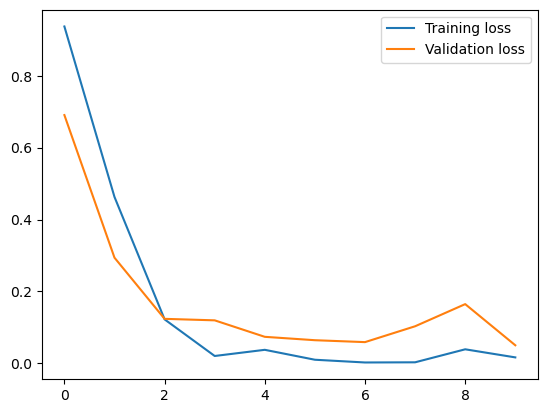

In [8]:
# Treinamento da rede
train_losses, test_losses = [], []
for epoch in tqdm(range(10)):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    accuracy = 100.0 * correct / total

    print(f"Epoch {epoch+1} - Training Loss: {running_loss/len(trainloader)}, Validation Loss: {test_loss/len(testloader)}, Accuracy: {accuracy}%")

print('Finished Training')

# Plotagem das curvas de treinamento e validação
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()
plt.show()

In [9]:
# Teste final de acuracia dos dados, matriz de confusão e f1 score

y_pred, y_true = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')}")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

F1 Score: 0.9853267966359927
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.97      0.97      0.97       150
ModerateDemented       1.00      0.92      0.96        13
     NonDemented       0.99      0.99      0.99       515
VeryMildDemented       0.99      0.99      0.99       346

        accuracy                           0.99      1024
       macro avg       0.99      0.97      0.98      1024
    weighted avg       0.99      0.99      0.99      1024

